# Stochastic gradient Langevin dynamics

In [1]:
import flax.linen as nn
import jax
import jax.numpy as jnp
import jax.random as jr
import jax.scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
from jax.flatten_util import ravel_pytree
from matplotlib.gridspec import GridSpec
from sklearn.preprocessing import StandardScaler

from pbnn.mcmc.langevin import sgld
from pbnn.utils.analytical_functions import g_function

%load_ext watermark

### Generate data

In [44]:
n = 200
noise_level = 1.0

np.random.seed(0)
X = 2 * np.random.rand(n, 2) - 1
X1_test, X2_test = np.meshgrid(np.linspace(-1, 1, 20), np.linspace(-1, 1, 20))
X_test = np.stack([X1_test.ravel(), X2_test.ravel()], axis=1)

noise, noise_test = (
    np.random.randn(n) * noise_level,
    np.random.randn(len(X_test)) * noise_level,
)

y = g_function(X, noise)
y_test = g_function(X_test, noise_test)

scaler = StandardScaler()
X_ = scaler.fit_transform(X)
X_test_ = scaler.transform(X_test)

X_, y = jnp.array(X_), jnp.array(y)
X_test_, y_test = jnp.array(X_test_), jnp.array(y_test)

### Define the network, loglikelihood and logprior 

In [49]:
# define loglikelihood et logprior
class MLP(nn.Module):
    """Simple MLP."""

    hidden_features: int
    out_features: int

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(
            features=self.hidden_features,
            kernel_init=nn.initializers.normal(),
            bias_init=nn.initializers.normal(),
        )(x)
        x = nn.tanh(x)
        x = nn.Dense(
            features=self.hidden_features,
            kernel_init=nn.initializers.normal(),
            bias_init=nn.initializers.normal(),
        )(x)
        x = nn.tanh(x)
        x = nn.Dense(
            features=self.out_features,
            kernel_init=nn.initializers.normal(),
            bias_init=nn.initializers.normal(),
        )(x)
        return x


network = MLP(hidden_features=100, out_features=1)


def loglikelihood_fn(parameters, data, sig_noise: float = noise_level):
    """Gaussian log-likelihood"""
    X, y = data
    return -jnp.sum(
        0.5 * (y - network.apply({"params": parameters}, X)) ** 2 / sig_noise**2
    )


def logprior_fn(parameters):
    """Compute the value of the log-prior density function."""
    flat_params, _ = ravel_pytree(parameters)
    return jnp.sum(stats.norm.logpdf(flat_params))

### Run the SGLD algorithm

In [50]:
# set some hyperparameters
step_size = 1e-6
num_iterations = 200_000
burnin = 180_000
batch_size = 32

# generate initial positions
rng_key = jr.PRNGKey(0)
keys = jr.split(rng_key)

init_positions = network.init(keys[0], X_)["params"]

# run SGLD
positions, ravel_fn, predict_fn = sgld(
    X=X_,
    y=y,
    loglikelihood_fn=loglikelihood_fn,
    logprior_fn=logprior_fn,
    init_positions=init_positions,
    batch_size=batch_size,
    step_size=step_size,
    num_iterations=num_iterations,
    rng_key=keys[1],
)

# remove burnin and thin manually
positions = jax.tree_util.tree_map(lambda xx: xx[burnin::100], positions)

# predict
f_predictions = predict_fn(network, positions, X_test_).squeeze()

# generate the noisy predictions
_, key = jr.split(keys[1])
y_predictions = f_predictions + noise_level * jr.normal(
    key, shape=(len(f_predictions), 1)
)

### Plot the prediction intervals

Array(0.63, dtype=float32)

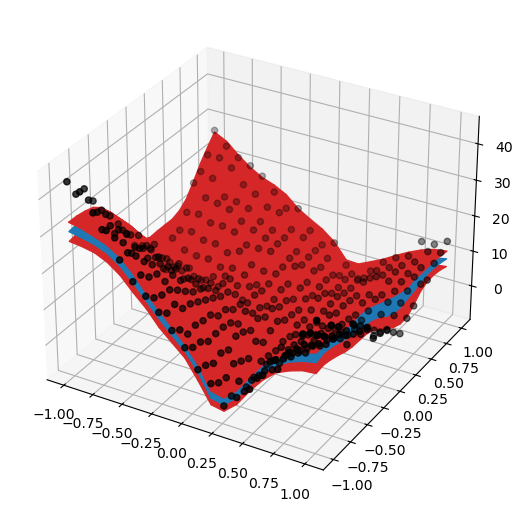

In [77]:
fig = plt.figure(constrained_layout=True, figsize=(5 * 5, 5))
gs = GridSpec(nrows=1, ncols=1, figure=fig)
alpha = 0.05

mean_prediction = jnp.median(y_predictions, axis=0)
qlow = jnp.quantile(y_predictions, 0.5 * alpha, axis=0)
qhigh = jnp.quantile(y_predictions, (1 - 0.5 * alpha), axis=0)

ax = fig.add_subplot(gs[0], projection="3d")
ax.scatter(X_test[:, 0], X_test[:, 1], y_test, marker="o", color="k")
ax.plot_surface(X1_test, X2_test, mean_prediction.reshape(20, 20), color="b", edgecolor="tab:blue", facecolor="tab:blue")
ax.plot_surface(X1_test, X2_test, qlow.reshape(20, 20), color="r", alpha=1, edgecolor="tab:red", facecolor="tab:red")
ax.plot_surface(X1_test, X2_test, qhigh.reshape(20, 20), color="r", alpha=1, edgecolor="tab:red", facecolor="tab:red")

# ax.scatter(X[:, 0], X[:, 1], y, marker="o", color="b")

In [6]:
%reload_ext watermark
%watermark -n -u -v -iv -w -a 'Brian Staber'

Author: Brian Staber

Last updated: Sat Mar 30 2024

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.21.0

numpy     : 1.26.3
jax       : 0.4.23
matplotlib: 3.8.2
flax      : 0.8.0

Watermark: 2.4.3

